In [36]:
# TODO: check all teams exist
# TODO: check all years exist

# STEP 1 - GATHERING DATA
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from matplotlib import pyplot as plt
import csv

seasons_df = pd.read_csv('ncaam-march-mania-2021/MDataFiles_Stage2/MSeasons.csv')
#print(seasons_df.head())

conferences_df = pd.read_csv('ncaam-march-mania-2021/MDataFiles_Stage2/Conferences.csv')
#print(conferences_df.head())

team_conferences_df = pd.read_csv('ncaam-march-mania-2021/MDataFiles_Stage2/MTeamConferences.csv')
#print(team_conferences_df.head())

tourney_seeds_df = pd.read_csv('ncaam-march-mania-2021/MDataFiles_Stage2/MNCAATourneySeeds.csv')
#print(tourney_seeds_df.head())

tourney_slots_df = pd.read_csv('ncaam-march-mania-2021/MDataFiles_Stage2/MNCAATourneySlots.csv')
#print(tourney_slots_df.head())

tourney_seed_round_slots_df = pd.read_csv('ncaam-march-mania-2021/MDataFiles_Stage2/MNCAATourneySeedRoundSlots.csv')
#print(tourney_seed_round_slots_df.head())

regseason_compact_results_df = pd.read_csv('ncaam-march-mania-2021/MDataFiles_Stage2/MRegularSeasonCompactResults.csv')
#print(regseason_compact_results_df.head())

tourney_compact_results_df = pd.read_csv('ncaam-march-mania-2021/MDataFiles_Stage2/MNCAATourneyCompactResults.csv')
#print(tourney_compact_results_df.head())

regseason_detailed_results_df = pd.read_csv('ncaam-march-mania-2021/MDataFiles_Stage2/MRegularSeasonDetailedResults.csv')
#print(regseason_detailed_results_df.head())

tourney_detailed_results_df = pd.read_csv('ncaam-march-mania-2021/MDataFiles_Stage2/MNCAATourneyDetailedResults.csv')
#print(tourney_detailed_results_df.head())

conference_tourney_games_df = pd.read_csv('ncaam-march-mania-2021/MDataFiles_Stage2/MConferenceTourneyGames.csv')
#print(conference_tourney_games_df.head())

massey_ordinals_df = pd.read_csv('ncaam-march-mania-2021/MDataFiles_Stage2/MMasseyOrdinals.csv')
#print(massey_ordinals_df.Season.unique())
#print(len(massey_ordinals_df.TeamID.unique()))

sample_submission_df = pd.read_csv('ncaam-march-mania-2021/MDataFiles_Stage2/MSampleSubmissionStage2.csv')
#print(sample_submission_df.head())

all_teams_pd = pd.read_csv('ncaam-march-mania-2021/MDataFiles_Stage2/MTeams.csv')
all_teams_list = all_teams_pd['TeamName'].tolist()

In [2]:

#REGULAR SEASON FEATURES


In [3]:
#Part 1 - Obtain TeamID, Season, Win %, Games Played, and PPG

#Find the game duration
regseason_compact_results_df['GameDuration'] = regseason_compact_results_df['NumOT']
for i in range(len(regseason_compact_results_df.NumOT.value_counts())):
    regseason_compact_results_df.loc[regseason_compact_results_df['NumOT'] == regseason_compact_results_df.NumOT.value_counts().index[i], 'GameDuration'] = 40 + i*5

regseason_compact_results_df['Wppg'] = regseason_compact_results_df['WScore'] * (40.0 / regseason_compact_results_df['GameDuration'])
regseason_compact_results_df['Lppg'] = regseason_compact_results_df['LScore'] * (40.0 / regseason_compact_results_df['GameDuration'])

regseason_compact_results_df_raw = regseason_compact_results_df

regseason_compact_results_df = regseason_compact_results_df.drop(['DayNum', 'WLoc', 'NumOT', 'WScore','LScore','GameDuration'],axis = 1)
#print(regseason_compact_results_df.Season.unique())

In [4]:
#Calculate average points per game and number of games for winning and losing team
Wppg_df = regseason_compact_results_df[["Season","WTeamID",'Wppg']].groupby(["Season","WTeamID"]).agg(['mean', 'count'])
Lppg_df = regseason_compact_results_df[["Season","LTeamID",'Lppg']].groupby(["Season","LTeamID"]).agg(['mean', 'count'])
Wppg_df.columns = Wppg_df.columns.droplevel(0)
Wppg_df = Wppg_df.reset_index().rename(columns = {'mean':'Wppg', 'count':'WGames'})
Lppg_df.columns = Lppg_df.columns.droplevel(0)
Lppg_df = Lppg_df.reset_index().rename(columns = {'mean':'Lppg', 'count':'LGames'})
#print(Wppg_df)
#print(Lppg_df)

In [5]:
#Merge PPG for wins and losses and fill NaNs with 0s for undefeated and no-win teams
ppg_df = pd.merge(Wppg_df, Lppg_df, left_on=['Season', 'WTeamID'], right_on=['Season', 'LTeamID'], how='outer')
ppg_df = ppg_df.fillna({'WTeamID': ppg_df.LTeamID, 'Wppg': 0, 'WGames': 0, 'LTeamID': ppg_df.WTeamID , 'Lppg': 0, 'LGames': 0})
#print(ppg_df.Season.unique())

In [6]:
#Calculate PPG and win percentage for season
ppg_df['PPG'] = (ppg_df['Wppg']*ppg_df['WGames'] + ppg_df['Lppg']*ppg_df['LGames'])/(ppg_df['WGames'] + ppg_df['LGames'])
ppg_df['WPerc'] = (ppg_df['WGames'])/(ppg_df['WGames'] + ppg_df['LGames'])
ppg_df['TeamID'] = ppg_df['WTeamID'].astype('int32')
ppg_df['GamesPlayed'] = (ppg_df['WGames'] + ppg_df['LGames'])
ppg_df = ppg_df.drop(['WTeamID', 'Wppg' ,'WGames','LTeamID', 'Lppg','LGames'],axis = 1)
#print(ppg_df.Season.unique())

In [7]:
#Part 2 - Obtain game level statistics:
    #2-PT field goal efficiency (2-PT field goals made per game / 2-PT field goals attempted per game)
    #3-PT field goal efficiency
    #Total field goal efficiency
    #Free throw efficiency
    #Assists per game
    #Blocks per game
    #Steals per game
    #Turnovers per game
    #Personal fouls per game
    #Offensive rebounds per game
    #Defensive rebounds per game
    #Points per shot
    #Total rebounds per game
    #Average turnovers to assists ratio
    #Average turnovers to steals ratio
    #Average scoring margin


#Gametime normalization
regseason_detailed_results_df['GameDuration'] = regseason_detailed_results_df['NumOT']
for i in range(len(regseason_detailed_results_df.NumOT.value_counts())):
    regseason_detailed_results_df.loc[regseason_detailed_results_df['NumOT'] == regseason_detailed_results_df.NumOT.value_counts().index[i], 'GameDuration'] = 40 + i*5

regseason_detailed_results_df['WFGM'] = (regseason_detailed_results_df['WFGM'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['WFGA'] = (regseason_detailed_results_df['WFGA'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['WFGM3'] = (regseason_detailed_results_df['WFGM3'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['WFGA3'] = (regseason_detailed_results_df['WFGA3'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['WFTM'] = (regseason_detailed_results_df['WFTM'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['WFTA'] = (regseason_detailed_results_df['WFTA'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['WOR'] = (regseason_detailed_results_df['WOR'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['WDR'] = (regseason_detailed_results_df['WDR'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['WAst'] = (regseason_detailed_results_df['WAst'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['WTO'] = (regseason_detailed_results_df['WTO'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['WStl'] = (regseason_detailed_results_df['WStl'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['WBlk'] = (regseason_detailed_results_df['WBlk'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['WPF'] = (regseason_detailed_results_df['WPF'] / regseason_detailed_results_df['GameDuration']) * 40

regseason_detailed_results_df['LFGM'] = (regseason_detailed_results_df['LFGM'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['LFGA'] = (regseason_detailed_results_df['LFGA'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['LFGM3'] = (regseason_detailed_results_df['LFGM3'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['LFGA3'] = (regseason_detailed_results_df['LFGA3'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['LFTM'] = (regseason_detailed_results_df['LFTM'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['LFTA'] = (regseason_detailed_results_df['LFTA'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['LOR'] = (regseason_detailed_results_df['LOR'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['LDR'] = (regseason_detailed_results_df['LDR'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['LAst'] = (regseason_detailed_results_df['LAst'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['LTO'] = (regseason_detailed_results_df['LTO'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['LStl'] = (regseason_detailed_results_df['LStl'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['LBlk'] = (regseason_detailed_results_df['LBlk'] / regseason_detailed_results_df['GameDuration']) * 40
regseason_detailed_results_df['LPF'] = (regseason_detailed_results_df['LPF'] / regseason_detailed_results_df['GameDuration']) * 40

#Calculate game level statistics for winning team

regseason_detailed_results_df["W2FG%"] = (regseason_detailed_results_df["WFGM"] / regseason_detailed_results_df["WFGA"])
regseason_detailed_results_df["W3FG%"] = (regseason_detailed_results_df["WFGM3"] / regseason_detailed_results_df["WFGA3"])
regseason_detailed_results_df["WFG%"] = (regseason_detailed_results_df["WFGM"] + regseason_detailed_results_df["WFGM3"] ) / (regseason_detailed_results_df["WFGA"] + regseason_detailed_results_df["WFGA3"])
regseason_detailed_results_df["WFT%"] = (regseason_detailed_results_df['WFTM'] / regseason_detailed_results_df['WFTA'])
regseason_detailed_results_df["WScoreMargin"] = regseason_detailed_results_df["WScore"] - regseason_detailed_results_df["LScore"]
regseason_detailed_results_df["WPPS"] = (regseason_detailed_results_df["WScore"]) / (regseason_detailed_results_df["WFGA"] + regseason_detailed_results_df["WFGA3"])
regseason_detailed_results_df["W#POS"] = regseason_detailed_results_df["WFGA"] + regseason_detailed_results_df["WFGA3"] - regseason_detailed_results_df['WOR'] + regseason_detailed_results_df['WTO'] + (0.4 * regseason_detailed_results_df['WFTA'])
regseason_detailed_results_df["WOEFF"] = (regseason_detailed_results_df["WScore"]) / (regseason_detailed_results_df["W#POS"])
regseason_detailed_results_df["WDEFF"] = (regseason_detailed_results_df["LScore"]) / (regseason_detailed_results_df["W#POS"])

#Calculate game level statistics for losing team

regseason_detailed_results_df["L2FG%"] = (regseason_detailed_results_df["LFGM"] / regseason_detailed_results_df["LFGA"])
regseason_detailed_results_df["L3FG%"] = (regseason_detailed_results_df["LFGM3"] / regseason_detailed_results_df["LFGA3"])
regseason_detailed_results_df["LFG%"] = (regseason_detailed_results_df["LFGM"] + regseason_detailed_results_df["LFGM3"] ) / (regseason_detailed_results_df["LFGA"] + regseason_detailed_results_df["LFGA3"])
regseason_detailed_results_df["LFT%"] = (regseason_detailed_results_df['LFTM'] / regseason_detailed_results_df['LFTA'])
regseason_detailed_results_df["LScoreMargin"] = (regseason_detailed_results_df["LScore"] - regseason_detailed_results_df["WScore"])
regseason_detailed_results_df["LPPS"] = (regseason_detailed_results_df["LScore"]) / (regseason_detailed_results_df["LFGA"] + regseason_detailed_results_df["LFGA3"])
regseason_detailed_results_df["L#POS"] = regseason_detailed_results_df["LFGA"] + regseason_detailed_results_df["LFGA3"] - regseason_detailed_results_df['LOR'] + regseason_detailed_results_df['LTO'] + (0.4 * regseason_detailed_results_df['LFTA'])
regseason_detailed_results_df["LOEFF"] = (regseason_detailed_results_df["LScore"]) / (regseason_detailed_results_df["L#POS"])
regseason_detailed_results_df["LDEFF"] = (regseason_detailed_results_df["WScore"]) / (regseason_detailed_results_df["L#POS"])
print(regseason_detailed_results_df.Season.unique())
#for col in regseason_detailed_results_df.columns:
    #print(col)



[2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017 2018 2019 2020 2021]


In [8]:
#Extract relevant columns and rename
Wstats_df = regseason_detailed_results_df[['Season',
                                           'DayNum',
                                           'WTeamID',
                                           'WScore',
                                           'WFGM',
                                           'WFGA',
                                           'WFGM3',
                                           'WFGA3',
                                           'WFTM',
                                           'WFTA',
                                           'WOR',
                                           'WDR',
                                           'WAst',
                                           'WTO',
                                           'WStl',
                                           'WBlk',
                                           'WPF',
                                           'W2FG%',
                                           'W3FG%',
                                           'WFG%',
                                           'WFT%',
                                           'WScoreMargin',
                                           'WPPS',
                                           'WOEFF',
                                           'WDEFF']]

Wstats_df = Wstats_df.rename(columns = {'WTeamID': 'TeamID',
                                        'WScore': 'AvgScore',
                                           'WFGM': 'FGM',
                                           'WFGA': 'FGA',
                                           'WFGM3': 'FGM3',
                                           'WFGA3': 'FGA3',
                                           'WFTM': 'FTM',
                                           'WFTA': 'FTA',
                                           'WOR': 'OR',
                                           'WDR': 'DR',
                                           'WAst': 'Ast',
                                           'WTO': 'TO',
                                           'WStl': 'Stl',
                                           'WBlk': 'Blk',
                                           'WPF': 'PF',
                                           'W2FG%': '2FG%',
                                           'W3FG%': '3FG%',
                                           'WFG%': 'FG%',
                                           'WFT%': 'FT%',
                                           'WScoreMargin': 'AvgScoreMarg',
                                           'WPPS': 'PPS',
                                           'WOEFF': 'OEFF',
                                           'WDEFF': 'DEFF'})

Lstats_df = regseason_detailed_results_df[['Season',
                                           'DayNum',
                                           'LTeamID',
                                           'LScore',
                                           'LFGM',
                                           'LFGA',
                                           'LFGM3',
                                           'LFGA3',
                                           'LFTM',
                                           'LFTA',
                                           'LOR',
                                           'LDR',
                                           'LAst',
                                           'LTO',
                                           'LStl',
                                           'LBlk',
                                           'LPF',
                                           'L2FG%',
                                           'L3FG%',
                                           'LFG%',
                                           'LFT%',
                                           'LScoreMargin',
                                           'LPPS',
                                           'LOEFF',
                                           'LDEFF']]

Lstats_df = Lstats_df.rename(columns = {'LTeamID': 'TeamID',
                                           'LScore': 'AvgScore',
                                           'LFGM': 'FGM',
                                           'LFGA': 'FGA',
                                           'LFGM3': 'FGM3',
                                           'LFGA3': 'FGA3',
                                           'LFTM': 'FTM',
                                           'LFTA': 'FTA',
                                           'LOR': 'OR',
                                           'LDR': 'DR',
                                           'LAst': 'Ast',
                                           'LTO': 'TO',
                                           'LStl': 'Stl',
                                           'LBlk': 'Blk',
                                           'LPF': 'PF',
                                           'L2FG%': '2FG%',
                                           'L3FG%': '3FG%',
                                           'LFG%': 'FG%',
                                           'LFT%': 'FT%',
                                           'LScoreMargin': 'AvgScoreMarg',
                                           'LPPS': 'PPS',
                                           'LOEFF': 'OEFF',
                                           'LDEFF': 'DEFF'})
stats_df = pd.concat([Wstats_df, Lstats_df])
#print(stats_df.Season.unique())


In [9]:
#Take seasonal and 30 day averages of the efficiency metrics
seasonAvgStats_df = stats_df.groupby(by = ['Season', 'TeamID']).agg('mean').reset_index().drop(['DayNum'], axis = 1)
#print(seasonAvgStats_df.Season.unique())

In [10]:
#Quick (haha, i wish. this takes forever) cleanup for 2020 season bc it was cut short
massey_ordinals_df['RankingDayNum'] = massey_ordinals_df.apply(lambda row: 133 if row['Season'] == 2020 and row['RankingDayNum'] == 128 else row['RankingDayNum'], axis=1)
massey_ordinals_df.tail()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
4339985,2021,133,WOB,1467,233
4339986,2021,133,WOB,1468,176
4339987,2021,133,WOB,1469,290
4339988,2021,133,WOB,1470,256
4339989,2021,133,WOB,1471,234


In [11]:
#Part 4 - Add Ranking Data
rankings_df = massey_ordinals_df[massey_ordinals_df['RankingDayNum'] == 133]
rankings_df = rankings_df.reset_index().drop(['index','RankingDayNum'], axis = 1)
mean_df = rankings_df.groupby(by = ['Season','TeamID'])[['OrdinalRank']].mean().reset_index()
mean_df = mean_df.rename(columns = {'OrdinalRank':'MeanRank'})

#Massey ordinals are missing for 2004-2009, but this shouldn't matter as we're only using data from 2015 forward
massey_ordinals_df = rankings_df[rankings_df['SystemName'] == 'MAS']
massey_ordinals_df = massey_ordinals_df.reset_index().drop(['index','SystemName'], axis = 1)
massey_ordinals_df = massey_ordinals_df.rename(columns = {'OrdinalRank':'MasseyRank'})
pomeroy_df = rankings_df[rankings_df['SystemName'] == 'POM']
pomeroy_df = pomeroy_df.reset_index().drop(['index','SystemName'], axis = 1)
pomeroy_df = pomeroy_df.rename(columns = {'OrdinalRank':'PomeroyRank'})
rankings_df = pd.merge(massey_ordinals_df, pomeroy_df, left_on=['Season', 'TeamID'], right_on=['Season', 'TeamID'], how='left')
rankings_df = pd.merge(rankings_df, mean_df, left_on=['Season', 'TeamID'], right_on=['Season', 'TeamID'], how='left')
rankings_df.head()

,Season,TeamID,MasseyRank,PomeroyRank,MeanRank
0,2003,1102,172,160,156.03125
1,2003,1103,163,163,168.00000
2,2003,1104,41,33,38.03125
3,2003,1105,310,307,308.96875
4,2003,1106,270,263,262.68750


In [168]:
#Part 5 - Merge ppg_df, seasonAvgStats_df, and rankings_df
features_df = pd.merge(ppg_df, seasonAvgStats_df)
features_df = pd.merge(features_df, rankings_df)
print(features_df.Season.unique())
print(len(features_df.TeamID.unique()))
print(features_df.head())
# for col in features_df.columns:
#     print(col)

[2003 2004 2005 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021]
362
   Season        PPG     WPerc  TeamID  GamesPlayed   AvgScore        FGM  \
0    2003  57.250000  0.428571    1102         28.0  57.250000  19.142857   
1    2003  75.967901  0.481481    1103         27.0  78.777778  26.268313   
2    2003  69.015873  0.607143    1104         28.0  69.285714  23.940476   
3    2003  70.400855  0.269231    1105         26.0  71.769231  23.938462   
4    2003  63.281746  0.464286    1106         28.0  63.607143  23.309524   

         FGA      FGM3       FGA3  ...      3FG%       FG%       FT%  \
0  39.785714  7.821429  20.821429  ...  0.367637  0.449465  0.642402   
1  54.051029  5.296296  15.611523  ...  0.331990  0.455683  0.735271   
2  56.964286  6.329365  19.805556  ...  0.325442  0.395264  0.705168   
3  60.519658  7.447009  20.373504  ...  0.359630  0.386880  0.709598   
4  55.019841  6.083333  17.567460  ...  0.350196  0.408169  0.623158   

   AvgScoreMarg       

In [153]:
#TOURNAMENT FEATURES

import collections

features_df[features_df['TeamID'] == 1276]

#Create a vector for a given team and season
def season_vector(team_id, year):
    temp_frame = features_df.query('TeamID == {} and Season == {}'.format(team_id, year))
    temp_frame = temp_frame[['PPG', 'WPerc', 'GamesPlayed', 'AvgScore', 'FGM',
       'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl',
       'Blk', 'PF', '2FG%', '3FG%', 'FG%', 'FT%', 'AvgScoreMarg', 'PPS',
       'OEFF', 'DEFF', 'MasseyRank', 'PomeroyRank', 'MeanRank']].values.flatten().tolist()
    return temp_frame

#Let's check out Michigan
print(season_vector(1276, 2021))

[75.875, 0.8333333333333334, 24.0, 76.25, 27.740740740740744, 57.33796296296296, 7.50462962962963, 19.375, 12.888888888888888, 16.564814814814813, 8.041666666666666, 26.930555555555554, 15.347222222222221, 10.574074074074074, 4.3842592592592595, 4.268518518518518, 6.208333333333333, 0.4824261299697255, 0.38650389914628897, 0.45783473758638543, 0.7873495994285301, 10.875, 0.9980204221742054, 0.8880092111997816, 0.7635120692747619, 4.0, 2.0, 4.833333333333333]


In [154]:
#Team Comparison

def compare_teams(team_id_1, team_id_2, year):
    team_1 = season_vector(team_id_1, year)
    team_2 = season_vector(team_id_2, year)
    comparison = [a - b for a, b in zip(team_1, team_2)]
    return comparison

#Let's compare Michigan and Ohio State
compare_teams(1211, 1325, 2021)

[11.751748251748253,
 0.31818181818181823,
 4.0,
 11.751748251748253,
 4.6083916083916066,
 1.3181818181818201,
 -1.2832167832167842,
 -3.46153846153846,
 3.8181818181818183,
 4.776223776223777,
 -0.26923076923077005,
 4.087412587412587,
 0.6713286713286699,
 0.3776223776223784,
 1.6713286713286717,
 0.8461538461538463,
 -0.5594405594405596,
 0.060405962332767904,
 -0.009446416911503552,
 0.04897407382611857,
 0.013093020443127545,
 15.954545454545453,
 0.159311245426346,
 0.1160019885664556,
 -0.04827369418724037,
 -81.0,
 -77.0,
 -82.36680911680912]

In [156]:
#Generate a vector for all teams in a given year

def all_teams_season(year):
    season_dictionary = collections.defaultdict(list)
    for team in all_teams_list:
        team_id = all_teams_pd[all_teams_pd['TeamName'] == team].values[0][0]
        team_vector = season_vector(team_id, year)
        season_dictionary[team_id] = team_vector
    return season_dictionary

#And make sure it still works with Michigan
all_teams_season(2020)[1211]

[87.17845117845117,
 0.9393939393939394,
 33.0,
 87.42424242424242,
 31.676767676767682,
 61.45791245791246,
 7.424242424242424,
 19.20875420875421,
 16.400673400673398,
 23.841750841750844,
 11.25925925925926,
 28.602693602693602,
 16.632996632996633,
 11.107744107744107,
 7.353535353535353,
 3.835016835016835,
 14.64983164983165,
 0.5173197356459529,
 0.40213114251401966,
 0.4879368333116363,
 0.6798876794970643,
 19.575757575757574,
 1.0941989086423705,
 0.9726238679198335,
 0.7582926819280109,
 2.0,
 2.0,
 3.2153846153846155]

In [157]:
#Add indicator for location instead of letter
def codify_home_away(row_num):
    if (row_num == 'H'):
        home = 1
    if (row_num == 'A'):
        home = -1
    if (row_num == 'N'):
        home = 0
    return home

In [158]:
#Time to create the training set!
def createTrainingSet(years):
    totalNumGames = 0
    for year in years:
        season = regseason_compact_results_df_raw[regseason_compact_results_df_raw['Season'] == year]
        totalNumGames += len(season.index)
        tourney = tourney_compact_results_df[tourney_compact_results_df['Season'] == year]
        totalNumGames += len(tourney.index)
    numFeatures = len(season_vector(1276,2020)) #Just choosing a random team and seeing the dimensionality of the vector
    xTrain = np.zeros(( totalNumGames, numFeatures + 1))
    yTrain = np.zeros(( totalNumGames ))
    indexCounter = 0
    for year in years:
        team_vectors = all_teams_season(year)
        season = regseason_compact_results_df_raw[regseason_compact_results_df_raw['Season'] == year]
        numGamesInSeason = len(season.index)
        tourney = tourney_compact_results_df[tourney_compact_results_df['Season'] == year]
        numGamesInSeason += len(tourney.index)
        xTrainSeason = np.zeros(( numGamesInSeason, numFeatures + 1))
        yTrainSeason = np.zeros(( numGamesInSeason ))
        counter = 0
        for index, row in season.iterrows():
            w_team = row['WTeamID']
            w_vector = team_vectors[w_team]
            l_team = row['LTeamID']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = codify_home_away(row['WLoc'])
            if (counter % 2 == 0):
                diff.append(home)
                xTrainSeason[counter] = diff
                yTrainSeason[counter] = 1
            else:
                diff.append(-home)
                xTrainSeason[counter] = [ -p for p in diff]
                yTrainSeason[counter] = 0
            counter += 1
        for index, row in tourney.iterrows():
            w_team = row['WTeamID']
            w_vector = team_vectors[w_team]
            l_team = row['LTeamID']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = 0 #All tournament games are neutral
            if (counter % 2 == 0):
                diff.append(home)
                xTrainSeason[counter] = diff
                yTrainSeason[counter] = 1
            else:
                diff.append(-home)
                xTrainSeason[counter] = [ -p for p in diff]
                yTrainSeason[counter] = 0
            counter += 1
        xTrain[indexCounter:numGamesInSeason+indexCounter] = xTrainSeason
        yTrain[indexCounter:numGamesInSeason+indexCounter] = yTrainSeason
        indexCounter += numGamesInSeason
    return xTrain, yTrain

year_list = range(2016,2022)
x_train, y_train = createTrainingSet(year_list)

In [163]:
x_train[9000]

array([ 5.62325405e+00,  4.50537634e-01,  1.00000000e+00,  5.63118280e+00,
        1.44561746e+00,  3.82889106e+00,  2.94634517e-01,  4.39404801e-01,
        2.43738460e+00,  3.55744542e+00,  4.12729445e-03,  4.34373846e+00,
       -1.11980015e-02,  3.37123927e-01,  6.96687303e-01,  3.21807321e+00,
        1.36455957e+00, -2.28080150e-03,  3.22757552e-03, -4.50357335e-04,
       -1.28915392e-02,  1.01440860e+01,  2.75071294e-02,  1.32555468e-02,
       -1.07511436e-01, -7.50000000e+01, -5.10000000e+01, -6.96338028e+01,
        1.00000000e+00])

In [21]:
#We need to normalize the data, so we'll do that below

from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x_train)
print(x_scaled.shape)
print(y_train.shape)
X_train, X_test, Y_train, Y_test = train_test_split(x_scaled, y_train)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(31083, 29)
(31083,)
(23312, 29) (7771, 29) (23312,) (7771,)


The accuracy is 0.7547291210912367


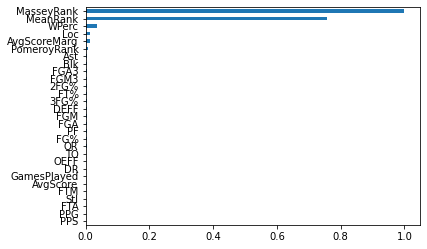

In [22]:
#FEATURE SELECTION

model = GradientBoostingRegressor(n_estimators=100)
model2 = linear_model.BayesianRidge()
model3 = KNeighborsClassifier(n_neighbors=128)
model4 = RandomForestClassifier(n_estimators=200)
model5 = AdaBoostClassifier(n_estimators=100)

def showFeatureImportance(my_categories):
    fx_imp = pd.Series(model.feature_importances_, index=my_categories)
    fx_imp /= fx_imp.max()
    fx_imp.sort_values()
    fx_imp.sort_values(ascending=True).plot(kind='barh')

categories = ['PPG', 'WPerc', 'GamesPlayed', 'AvgScore', 'FGM',
       'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl',
       'Blk', 'PF', '2FG%', '3FG%', 'FG%', 'FT%', 'AvgScoreMarg', 'PPS',
       'OEFF', 'DEFF', 'MasseyRank', 'PomeroyRank', 'MeanRank', 'Loc']


accuracy=[]
totals=[]
for i in range(1):
    results1 = model.fit(X_train, Y_train)
    preds1 = model.predict(X_test)

    results2 = model2.fit(X_train, Y_train)
    preds2 = model2.predict(X_test)

    results3 = model3.fit(X_train, Y_train)
    preds3 = model3.predict(X_test)

    results4 = model4.fit(X_train, Y_train)
    preds4 = model4.predict(X_test)

    results5 = model5.fit(X_train, Y_train)
    preds5 = model5.predict(X_test)

    preds = (preds1 + preds2 + preds3 + preds4 + preds5)/5
    totals.append(preds)
    preds[preds < .5] = 0
    preds[preds >= .5] = 1
    accuracy.append(np.mean(preds == Y_test))
    #accuracy.append(np.mean(predictions == Y_test))
print("The accuracy is", sum(accuracy)/len(accuracy))
showFeatureImportance(categories)

In [141]:
#Lets Eliminate some features, because too many can be bad.
#Lets choose the top 15 (not including Massey Rank)

def season_vector(team_id, year):
    temp_frame = features_df.query('TeamID == {} and Season == {}'.format(team_id, year))
    temp_frame = temp_frame[[ 'MasseyRank', 'WPerc', 'AvgScoreMarg', 'PomeroyRank',
       'Ast', 'Blk', 'FGA3', 'FGM3', '2FG%', 'FT%', '3FG%',
       'DEFF', 'FGM', 'FGA', 'PF']].values.flatten().tolist()
    return temp_frame

#Time to create the training set!
def createTrainingSet(years):
    totalNumGames = 0
    for year in years:
        season = regseason_compact_results_df_raw[regseason_compact_results_df_raw['Season'] == year]
        totalNumGames += len(season.index)
        tourney = tourney_compact_results_df[tourney_compact_results_df['Season'] == year]
        totalNumGames += len(tourney.index)
    numFeatures = len(season_vector(1276,2020)) #Just choosing a random team and seeing the dimensionality of the vector
    xTrain = np.zeros(( totalNumGames, numFeatures + 1))
    yTrain = np.zeros(( totalNumGames ))
    indexCounter = 0
    for year in years:
        team_vectors = all_teams_season(year)
        season = regseason_compact_results_df_raw[regseason_compact_results_df_raw['Season'] == year]
        numGamesInSeason = len(season.index)
        tourney = tourney_compact_results_df[tourney_compact_results_df['Season'] == year]
        numGamesInSeason += len(tourney.index)
        xTrainSeason = np.zeros(( numGamesInSeason, numFeatures + 1))
        yTrainSeason = np.zeros(( numGamesInSeason ))
        counter = 0
        for index, row in season.iterrows():
            w_team = row['WTeamID']
            w_vector = team_vectors[w_team]
            l_team = row['LTeamID']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = codify_home_away(row['WLoc'])
            if (counter % 2 == 0):
                diff.append(home)
                xTrainSeason[counter] = diff
                yTrainSeason[counter] = 1
            else:
                diff.append(-home)
                xTrainSeason[counter] = [ -p for p in diff]
                yTrainSeason[counter] = 0
            counter += 1
        for index, row in tourney.iterrows():
            w_team = row['WTeamID']
            w_vector = team_vectors[w_team]
            l_team = row['LTeamID']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = 0 #All tournament games are neutral
            if (counter % 2 == 0):
                diff.append(home)
                xTrainSeason[counter] = diff
                yTrainSeason[counter] = 1
            else:
                diff.append(-home)
                xTrainSeason[counter] = [ -p for p in diff]
                yTrainSeason[counter] = 0
            counter += 1
        xTrain[indexCounter:numGamesInSeason+indexCounter] = xTrainSeason
        yTrain[indexCounter:numGamesInSeason+indexCounter] = yTrainSeason
        indexCounter += numGamesInSeason
    return xTrain, yTrain

year_list = range(2016,2022)
x_train, y_train = createTrainingSet(year_list)

#We need to normalize the data, so we'll do that below

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(x_train)
x_scaled = scaler.transform(x_train)
print(x_scaled.shape)
print(y_train.shape)
X_train, X_test, Y_train, Y_test = train_test_split(x_scaled, y_train)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(31083, 16)
(31083,)
(23312, 16) (7771, 16) (23312,) (7771,)


In [142]:
#CHOOSE MODELS

#Logistic Regression

model = linear_model.LogisticRegression(max_iter=1000)

accuracy=[]

results = model.fit(X_train, Y_train)
preds = model.predict(X_test)
preds[preds < .5] = 0
preds[preds >= .5] = 1
accuracy.append(np.mean(preds == Y_test))
#accuracy.append(np.mean(predictions == Y_test))
print("Finished iteration:", results.n_iter_)
print("The accuracy is", sum(accuracy)/len(accuracy))

Finished iteration: [72]
The accuracy is 0.7531849182859349


Minimum error:- 0.24783311297194066 at K = 134


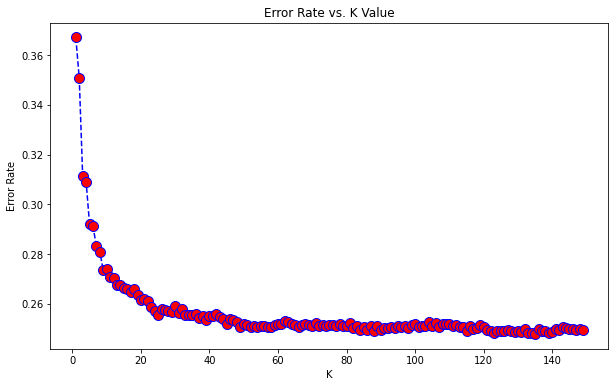

In [127]:
#KNN
#Next two cells show minimum error, maximum accuracy, and the value of K where this occurs
#Quick sanity check - KNN is usually best when K is close to sqrt(num samples)
#This value is sqrt(16425) = 128 and K=115

error_rate = []
for i in range(1,150):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,Y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != Y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,150),error_rate,color='blue', linestyle='dashed',
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

Maximum accuracy:- 0.7521668870280593 at K = 134


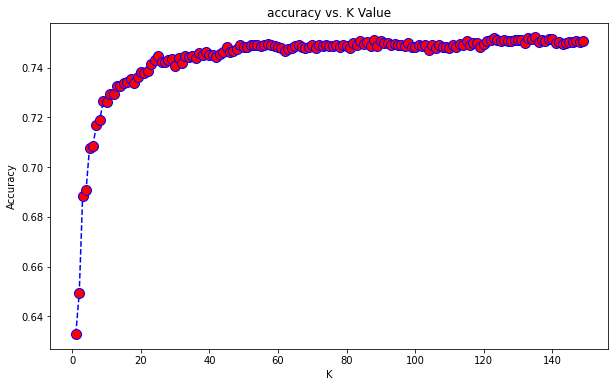

In [128]:
acc = []
# Will take some time
from sklearn import metrics
for i in range(1,150):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,Y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(Y_test, yhat))

plt.figure(figsize=(10,6))
plt.plot(range(1,150),acc,color = 'blue',linestyle='dashed',
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

In [135]:
from sklearn import svm

model = svm.SVC()

accuracy=[]

results = model.fit(X_train, Y_train)
preds = model.predict(X_test)
preds[preds < .5] = 0
preds[preds >= .5] = 1
accuracy.append(np.mean(preds == Y_test))
#accuracy.append(np.mean(predictions == Y_test))
print("The accuracy is", sum(accuracy)/len(accuracy))

The accuracy is 0.759361729507142


In [143]:
#Lets try some other cool models like Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=100)

accuracy=[]

results = model.fit(X_train, Y_train)
preds = model.predict(X_test)
preds[preds < .5] = 0
preds[preds >= .5] = 1
accuracy.append(np.mean(preds == Y_test))
#accuracy.append(np.mean(predictions == Y_test))
print("The accuracy is", sum(accuracy)/len(accuracy))

The accuracy is 0.752670184017501


In [144]:
#STEP 7 - CREATE FINAL PREDICTIONS FOR 2021 TOURNAMENT

prediction_df = pd.read_csv('ncaam-march-mania-2021/MDataFiles_Stage2/MSampleSubmissionStage2.csv')
prediction_df.head()

,ID,Pred
0,2021_1101_1104,0.5
1,2021_1101_1111,0.5
2,2021_1101_1116,0.5
3,2021_1101_1124,0.5
4,2021_1101_1140,0.5


In [145]:
def predictGame(team_1_vector, team_2_vector, home):
    diff = [a - b for a, b in zip(team_1_vector, team_2_vector)]
    diff.append(home)
    return model.predict_proba([diff])

games = []
for index, row in prediction_df.iterrows():
        matchup_id = row['ID']
        year = matchup_id[0:4]
        team1_id = matchup_id[5:9]
        team2_id = matchup_id[10:14]
        team1_vector = season_vector(int(team1_id), int(year))
        team2_vector = season_vector(int(team2_id), int(year))
        pred = predictGame(team1_vector, team2_vector, 0)
        results = [matchup_id, pred]
        games.append(results)
with open("result.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(games)